In [12]:
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from venn import venn

# Analysis of Overlap and Differences in Functionally Redundant Paralog Pairs Across Different Datasets/Labels

Load sequence features/labels/pair-subsets from `./data`

In [13]:
# Load datasets 
cols_to_use_pairs = ['sorted_gene_pair', 'SL', 'min_sequence_identity'] 
cols_to_use_pairs_func = ['sorted_gene_pair', 'same_func_ppi', 'min_sequence_identity'] 
# Human
go_hs_df = pd.read_csv('./data/ens111_human_BPO.csv', usecols=cols_to_use_pairs_func)
go_hs_df['SL'] = go_hs_df['same_func_ppi']
goCCO_hs_df = pd.read_csv('./data/ens111_human_CCO.csv', usecols=cols_to_use_pairs_func)
goCCO_hs_df['SL'] = goCCO_hs_df['same_func_ppi']
goMFO_hs_df = pd.read_csv('./data/ens111_human_MFO.csv', usecols=cols_to_use_pairs_func)
goMFO_hs_df['SL'] = goMFO_hs_df['same_func_ppi']
bioplex_hs_df = pd.read_csv('./data/ens111_human_BioPlex.csv', usecols=cols_to_use_pairs_func)
bioplex_hs_df['SL'] = bioplex_hs_df['same_func_ppi']
depmap_hs_df = pd.read_csv('./data/ens111_human_SL.csv', usecols=cols_to_use_pairs)
# Yeast
interactome_sc_df = pd.read_csv('./data/ens111_yeast_Interactome.csv', usecols=cols_to_use_pairs_func)
interactome_sc_df['SL'] = interactome_sc_df['same_func_ppi']
sl_sc_df = pd.read_csv('./data/ens111_yeast_SL.csv', usecols=cols_to_use_pairs)


In [14]:
# Setup font size for figures
plt.rcParams.update({'font.size': 22})

# Overlap of Pairs Sharing Common Functions Across Yeast Datasets

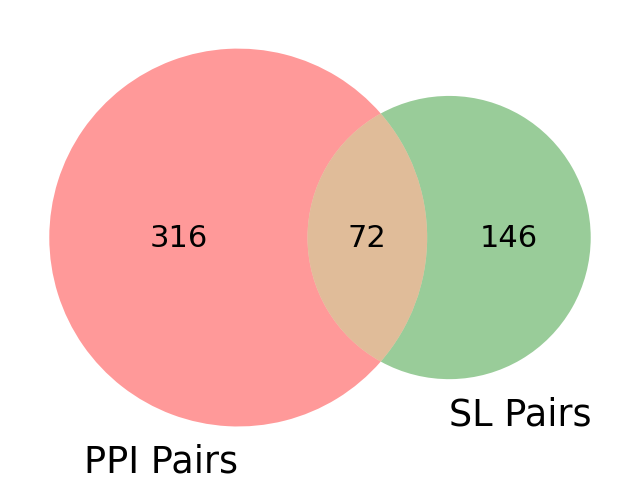

In [15]:
# Filter to get only True SL values and extract sorted_gene_pair
go_sc_pairs = set(interactome_sc_df[interactome_sc_df['SL']]['sorted_gene_pair'])
biogrid_sc_pairs = set(interactome_sc_df[interactome_sc_df['SL']]['sorted_gene_pair'])
sl_sc_pairs = set(sl_sc_df[sl_sc_df['SL']]['sorted_gene_pair'])

# Create a Venn diagram
plt.figure(figsize=(8, 8))
plt.rcParams.update({'font.size': 22})
venn2([biogrid_sc_pairs, sl_sc_pairs], ('PPI Pairs', 'SL Pairs'))
#plt.title('Overlap of Functionaly Redundant Paralog Pairs in Yeast Datasets')
plt.show()

In [16]:
# Perform Fisher Exact Test (FET)

# Function to extract sets based on SL value
def extract_sets(df):
    true_set = set(df[df['SL']]['sorted_gene_pair'])
    false_set = set(df[~df['SL']]['sorted_gene_pair'])
    return true_set, false_set

def perform_fet(set1_true, set2_true, set1_false, set2_false):
    # Calculate the intersections and differences
    shared_true = len(set1_true.intersection(set2_true))  # True in both datasets

    # Assuming some elements might be absent (neither True nor False)
    only_set1_true = len(set1_true - set2_true)  # True in set1 but not in set2 (do not consider Abs)
    only_set2_true = len(set2_true - set1_true)  # True in set2 but not in set1 (do not consider Abs)

    # False in both datasets - used for better clarity and complete comparison
    shared_false = len(set1_false.intersection(set2_false)) # (do not consider Abs)
    
    # Construct the contingency table without the 'neither' category
    # Note: 'neither' normally accounts for not being in either set, which we don't need here
    #     Dataset 2
    #               T                                       |        F
    # T  |  shared_true (True in both)                      |    only_set1_true (True in set1, False/Abs in set2)
    # F  |  only_set2_true (False/Abs in set1, True in set2)    |    shared_false (False/Abs in both)
    ctab = [
        [shared_true, only_set1_true],   # True in set 1 comparisons
        [only_set2_true, shared_false]   # False in set 1 comparisons
    ]

    # Perform the Fisher Exact Test
    odds_ratio, p_value = fisher_exact(ctab, alternative='two-sided')
    #log_p_value = -np.log10(p_value) if p_value > 0 else float('inf')
    
    if p_value==0: # Use smallest float64 number, to apply log10
        p_value = np.nextafter(0, 1)
    log_p_value = (-np.log10(p_value)) if p_value != 1 else 0
    log_p_value = -log_p_value if odds_ratio < 1 else log_p_value # return negative pval if signif depletion in overlap

    return p_value, odds_ratio

In [17]:
# Extract True and False sets for each dataset
interactome_true, interactome_false = extract_sets(interactome_sc_df)
sl_true, sl_false = extract_sets(sl_sc_df)

# Calculate Fisher Exact Test for each pair
log_pval_biogrid_sl, or_biogrid_sl = perform_fet(interactome_true, sl_true, interactome_false, sl_false)

print(f"FET PPI vs SL: p-value = {log_pval_biogrid_sl}, Odds Ratio = {or_biogrid_sl}")


FET PPI vs SL: p-value = 5.2384160387228456e-08, Odds Ratio = 2.4532685971909136


# Overlap of Pairs Sharing Common Functions Across Human Datasets

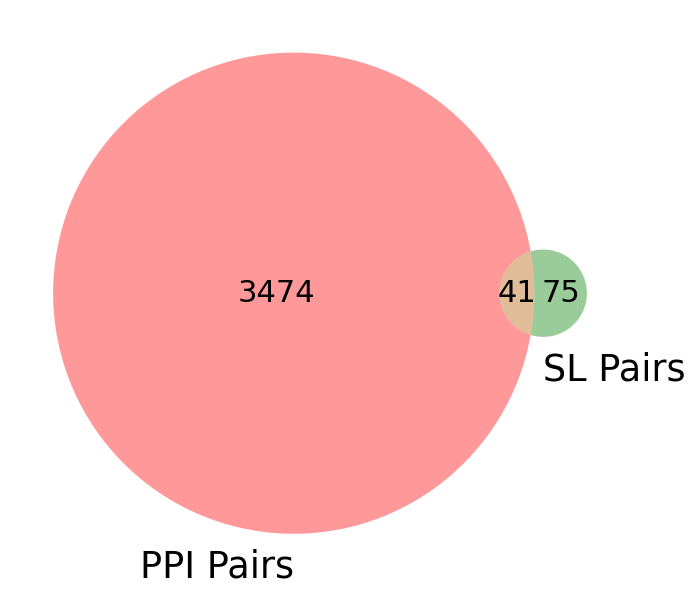

In [18]:
# Filter to get only True SL values and extract sorted_gene_pair
go_hs_pairs = set(go_hs_df[go_hs_df['SL']]['sorted_gene_pair'])
bioplex_hs_pairs = set(bioplex_hs_df[bioplex_hs_df['SL']]['sorted_gene_pair'])
depmap_hs_pairs = set(depmap_hs_df[depmap_hs_df['SL']]['sorted_gene_pair'])

# Create a Venn diagram
plt.figure(figsize=(8, 8))
#venn3([go_hs_pairs, bioplex_hs_pairs, lenient_hs_pairs], ('GO Pairs', 'PPI Pairs', 'SL Pairs'))
venn2([bioplex_hs_pairs, depmap_hs_pairs], ('PPI Pairs', 'SL Pairs'))
#plt.title('Overlap of Functionaly Redundant Paralog Pairs in Human Datasets')
plt.show()

In [19]:
# Extract True and False sets for each dataset
go_true, go_false = extract_sets(go_hs_df)
goCCO_true, goCCO_false = extract_sets(goCCO_hs_df)
goMFO_true, goMFO_false = extract_sets(goMFO_hs_df)
bioplex_true, bioplex_false = extract_sets(bioplex_hs_df)
depmap_true, depmap_false = extract_sets(depmap_hs_df)

# Calculate Fisher Exact Test for each pair
log_pval_goCCO_go, or_goCCO_go = perform_fet(goCCO_true, go_true, goCCO_false, go_false)
log_pval_goCCO_goMFO, or_goCCO_goMFO = perform_fet(goCCO_true, goMFO_true, goCCO_false, goMFO_false)
log_pval_goCCO_depmap, or_goCCO_depmap = perform_fet(goCCO_true, depmap_true, goCCO_false, depmap_false)
log_pval_bioplex_goCCO, or_bioplex_goCCO = perform_fet(bioplex_true, goCCO_true, bioplex_false, goCCO_false)
log_pval_goMFO_go, or_goMFO_go = perform_fet(goMFO_true, go_true, goMFO_false, go_false)
log_pval_goMFO_depmap, or_goMFO_depmap = perform_fet(goMFO_true, depmap_true, goMFO_false, depmap_false)
log_pval_bioplex_goMFO, or_bioplex_goMFO = perform_fet(bioplex_true, goMFO_true, bioplex_false, goMFO_false)
log_pval_go_depmap, or_go_depmap = perform_fet(go_true, depmap_true, go_false, depmap_false)
log_pval_bioplex_go, or_bioplex_go = perform_fet(bioplex_true, go_true, bioplex_false, go_false)
log_pval_bioplex_depmap, or_bioplex_depmap = perform_fet(bioplex_true, depmap_true, bioplex_false, depmap_false)

# Printing Fisher Exact Test results
print(f"FET Bioplex vs DepMap: p-value = {log_pval_bioplex_depmap}, Odds Ratio = {or_bioplex_depmap}")


FET Bioplex vs DepMap: p-value = 5.8146012241586324e-08, Odds Ratio = 3.104072155056611


<Figure size 1200x1200 with 0 Axes>

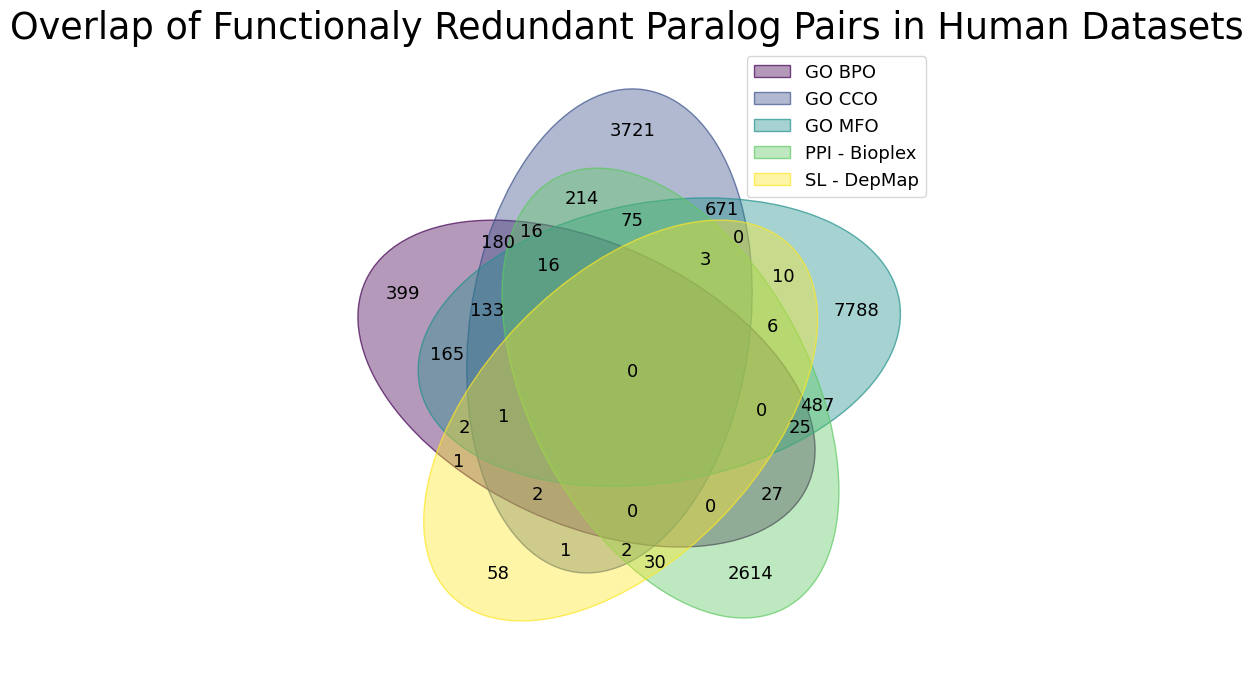

In [9]:
# Filter to get only True SL values and extract sorted_gene_pair
datasets = {
    'GO BPO': set(go_hs_df[go_hs_df['SL']]['sorted_gene_pair']),
    'GO CCO': set(goCCO_hs_df[goCCO_hs_df['SL']]['sorted_gene_pair']),
    'GO MFO': set(goMFO_hs_df[goMFO_hs_df['SL']]['sorted_gene_pair']),
    'PPI - Bioplex': set(bioplex_hs_df[bioplex_hs_df['SL']]['sorted_gene_pair']),
    'SL - DepMap': set(depmap_hs_df[depmap_hs_df['SL']]['sorted_gene_pair']),
}

# Create a Venn diagram
plt.figure(figsize=(12, 12))
venn(datasets)
plt.title('Overlap of Functionaly Redundant Paralog Pairs in Human Datasets')
plt.show()